<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/37_4_Translate_%2B_Bogdanov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from random import randint
import unicodedata
import re
import pandas as pd
import tensorflow as tf
import os
import time

from keras.models import Model, load_model
from keras.layers import Dense, Embedding, GRU, Input, Dense, Embedding, Bidirectional, Concatenate, Dropout, Dot
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
!wget https://storage.yandexcloud.net/academy.ai/rus-eng.zip

--2025-01-28 16:17:07--  https://storage.yandexcloud.net/academy.ai/rus-eng.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16305013 (16M) [application/x-zip-compressed]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  15.55M  8.94MB/s    in 1.7s    

2025-01-28 16:17:10 (8.94 MB/s) - ‘rus-eng.zip’ saved [16305013/16305013]



In [3]:
!unzip -o rus-eng.zip

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [4]:
BATCH_SIZE     = 512       # размер обучающего пакета.
EPOCHS         = 3         # число эпох обучения.
UNITS          = 1024      # число нейронов в рекуррентных с слоях.
EMBED_DIM      = 256       # размерность эмбеддинга.
NUM_SAMPLES    = 2500      # число примеров для обучения.
FILE_NAME      = "rus.txt" # имя файла со словарем в архиве
SOS            = '<start>' # токен начала последовательсти
EOS            = '<end>'   # токен окончания последовательсти

In [5]:
def preprocess_sentence(w):
    w = re.sub(r"([?.!,;:¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Zа-яёА-ЯЁ?'`.!,;:¿]+", " ", w)
    w = w.rstrip().strip()
    w = SOS + ' ' + w + ' ' + EOS

    return w

In [6]:
questions = [] # список входных фраз
answers = []   # список ответных фраз

with open(FILE_NAME, "r", encoding="utf-8") as f: # открываем файл в режиме чтения
    lines = f.read().split("\n")                    # считываем весь файл, разделяя на строки

for line in lines[: min(NUM_SAMPLES, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    questions.append(preprocess_sentence(input_text))
    answers.append(preprocess_sentence(target_text))

print("Число примеров:", len(answers))
random_index = randint(0, len(questions)-1)
print(f'Вопрос : {questions[random_index]}') # Пример входной фразы
print(f'Ответ : {answers[random_index]}')    # Пример ответной фразы

Число примеров: 2500
Вопрос : <start> Ask anyone . <end>
Ответ : <start> Спроси у кого нибудь . <end>


In [7]:
def tokenize(text): # функция принимает текст на заданном языке
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    pseq = pad_sequences(seq, padding='post')
    return pseq, tokenizer

In [8]:
paddedQuestions, tokenizer_en = tokenize(questions)    # формируем вектор фикс длины для вопросов  и токенизатор для английского языка
paddedAnswers, tokenizer_ru   = tokenize(answers)      # формируем вектор фикс длины для ответов  и токенизатор для русского языка

In [9]:
max_length_ru = paddedAnswers.shape[1]
max_length_en = paddedQuestions.shape[1]

In [10]:
questions_train, questions_val, answers_train, answers_val = train_test_split(paddedQuestions, paddedAnswers, test_size=0.2)

In [11]:
BUFFER_SIZE = len(questions_train)                     # случайно сэмплировать будем по всей длине обучающейся выборки
STEPS_PER_EPOCH = len(questions_train)//BATCH_SIZE     # количество шагов в одной эпохе
VOCAB_EN_SIZE = len(tokenizer_en.word_index) + 1
VOCAB_RU_SIZE = len(tokenizer_ru.word_index) + 1

In [12]:
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Исходный язык:")
convert(tokenizer_en, questions_train[0])
print ()
print ("Целевой язык:")
convert(tokenizer_ru, answers_train[0])

Исходный язык:
1 ----> <start>
9 ----> tom
581 ----> began
3 ----> .
2 ----> <end>

Целевой язык:
1 ----> <start>
8 ----> том
1451 ----> начал
3 ----> .
2 ----> <end>


In [13]:
dataset = tf.data.Dataset.from_tensor_slices((questions_train, answers_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [14]:
example_questions_batch, example_answers_batch = next(iter(dataset))
print('Форма батчей ENG и RU: ', example_questions_batch.shape, example_answers_batch.shape)

Форма батчей ENG и RU:  (512, 7) (512, 9)


In [15]:
class Encoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()                                   # вызываем инициализацию родительского класса

        self.batch_sz = batch_sz                                          # инициализируем переменную размера батча внутри класса
        self.enc_units = enc_units                                        # инициализируем переменную размера слоя в кодировщике
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)             # инициализируем слой эмбеддинга с заданными параметрами
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform') # инициализируем рекуррентный слой с заданными параметрами

    def call(self, x, hidden):   # начальное состояние
        x = self.embedding(x)   # входящие тензоры преобразовываются эмбеддингом
        output, state = self.gru(x, initial_state = hidden) # далее пропускаем через слой GRU и получаем выходные данные и новое состояние
        return output, state # выход сети и состояние на выходе

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [16]:
encoder = Encoder(VOCAB_EN_SIZE, EMBED_DIM, UNITS, BATCH_SIZE)

In [17]:
# ВЫБОР МЕХАНИЗМА ВНИМАНИЯ
choice_dict = {"BG": "Механизм внимания Богданова",
               "LP": "Luong + точечное внимание",
               "LG": "Luong + общее внимание",
               "LU": "Luong + объединенное внимание"}

choice_attention_mechanism = input('''Выбор механизма внимания:
                                      BG - Механизм внимания Богданова
                                      LP - Luong + точечное внимание
                                      LG - Luong + общее внимание
                                      LU - Luong + объединенное внимание
                                      ==> ''')

print(f'Выбран: {choice_dict[choice_attention_mechanism]}')

Выбор механизма внимания:
                                      BG - Механизм внимания Богданова
                                      LP - Luong + точечное внимание
                                      LG - Luong + общее внимание
                                      LU - Luong + объединенное внимание 
                                      ==> LG
Выбран: Luong + общее внимание


In [18]:
class BLA(Model):

    def __init__(self, units):
        super(BLA, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V =  Dense(1)

    if choice_attention_mechanism == "BG": # Механизм внимания Богданова
        def call(self, hidden_state, values):
            hidden_with_time_axis = tf.expand_dims(hidden_state, 1)
            score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
            attention_weights = tf.nn.softmax(score, axis=1)
            context_vector = attention_weights * values
            context_vector = tf.reduce_sum(context_vector, axis=1)
            return context_vector, attention_weights

            attention_layer = BLA(10)


    elif choice_attention_mechanism == "LP": # Luong + точечное внимание
        def call(self, hidden_state, values):
            hidden_with_time_axis = tf.expand_dims(hidden_state, 1)
            values_transposed = tf.transpose(values, perm=[0, 2, 1])
            score = tf.transpose(tf.matmul(hidden_with_time_axis, values_transposed), perm=[0, 2, 1])
            attention_weights = tf.nn.softmax(score, axis=1)
            context_vector = attention_weights * values
            context_vector = tf.reduce_sum(context_vector, axis=1)
            return context_vector, attention_weights

            attention_layer = BLA()


    elif choice_attention_mechanism == "LG":  # Luong + общее внимание
        def call(self, hidden_state, values):
            hidden_with_time_axis = tf.expand_dims(hidden_state, 1)
            values_transposed = tf.transpose(values, perm=[0, 2, 1])
            score = tf.transpose(tf.matmul(hidden_with_time_axis, values_transposed), perm=[0, 2, 1])
            attention_weights = tf.nn.softmax(score, axis=2)
            context_vector = tf.reduce_sum(attention_weights * values, axis=1)
            return context_vector, attention_weights

            attention_layer = BLA()


    elif choice_attention_mechanism == "LU":  # Luong + объединенное внимание
        def call(self, hidden_state, values):
            hidden_with_time_axis = tf.expand_dims(hidden_state, 1)
            repeated_hidden = tf.tile(hidden_with_time_axis, [1, tf.shape(values)[1], 1])
            concatenated = tf.concat([repeated_hidden, values], axis=-1)
            score = tf.transpose(self.V(tf.nn.tanh(self.W1(concatenated))), perm=[0, 2, 1])
            score = tf.transpose(score, perm=[0, 2, 1])
            attention_weights = tf.nn.softmax(score, axis=2)
            context_vector = tf.reduce_sum(attention_weights * values, axis=1)
            return context_vector, attention_weights

            attention_layer = BLA()

    else:
        print("Механизм внимания не выбран!")

In [19]:
class Decoder(Model):

    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()                       # вызываем инициализацию родительского класса

        self.batch_sz = batch_sz                              # инициализируем переменную размера батча внутри класса
        self.dec_units = dec_units                            # инициализируем переменную размера слоя в декодировщике
        self.embedding = Embedding(vocab_size, embedding_dim) # инициализируем слой эмбеддинга с заданными параметрами
        self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform') # инициализируем рекуррентный слой с заданными параметрами
        self.fc = Dense(vocab_size) # полносвязный слой с размером словаря
        self.attention = BLA(self.dec_units) # механизм внимания

    def call(self, x, hidden, enc_output):

        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x, initial_state = hidden)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, state, attention_weights

In [20]:
decoder = Decoder(VOCAB_RU_SIZE, EMBED_DIM, UNITS, BATCH_SIZE)

In [21]:
optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(real, pred)
    mask = tf.cast(mask, dtype=loss.dtype) # приводим тип маски к типу потерь
    loss *= mask                           # маскируем потери, избавляемся от заполняющих нулей

    return tf.reduce_mean(loss) # вернем среднее значение тензора

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [23]:
@tf.function
def train_step(inp, targ, enc_hidden): # определим входную фразу, перевод и состояние кодировщика
  loss = 0 # переменная для фиксации ошибки

  with tf.GradientTape() as tape:
      enc_output, enc_hidden = encoder(inp, enc_hidden)
      dec_hidden = enc_hidden
      dec_input = tf.expand_dims([tokenizer_ru.word_index[SOS]] * BATCH_SIZE, 1)

      for t in range(1, targ.shape[1]): # для каждого слова из фразы
          predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
          loss += loss_function(targ[:, t], predictions)
          dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [24]:
for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(STEPS_PER_EPOCH)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    print(f'Эпоха: {epoch + 1}  |  Потеря:  {(total_loss / STEPS_PER_EPOCH):.4f}  |  Время на эпоху: {time.time() - start} сек \n' )

Эпоха: 1  |  Потеря:  2.9402  |  Время на эпоху: 38.667118549346924 сек 

Эпоха: 2  |  Потеря:  2.5656  |  Время на эпоху: 26.799120664596558 сек 

Эпоха: 3  |  Потеря:  1.9690  |  Время на эпоху: 26.799891710281372 сек 



In [25]:
def evaluate(sentence):

    attention_plot = np.zeros((max_length_ru, max_length_en))
    sentence = preprocess_sentence(sentence)
    words = sentence.split(' ')
    inputs = list() # список для сбора токенов

    for word in words:
        try:
            inputs.append(tokenizer_en.word_index[word]) # находим индекс в словаре и добавляем в список
        except:
            pass # игнорируем слово, которое не знаем

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_en, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    print(inputs)
    result = ''
    hidden = [tf.zeros((1, UNITS))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer_ru.word_index[SOS]], 0)

    for t in range(max_length_ru):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += tokenizer_ru.index_word[predicted_id] + ' '

        if tokenizer_ru.index_word[predicted_id] == EOS:
            return result, sentence, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [26]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis') # рисуем 2d матрицу
    fontdict = {'fontsize': 14}           # размер текста
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90) # подписи по горизонтали
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)    # подписи по вертикали
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [27]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Ввод: %s' % (sentence))
    print(f'Перевод: {result}')
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

tf.Tensor([[  1 174   2   0   0   0   0]], shape=(1, 7), dtype=int32)
Ввод: <start> moon red <end>
Перевод: я <end> 


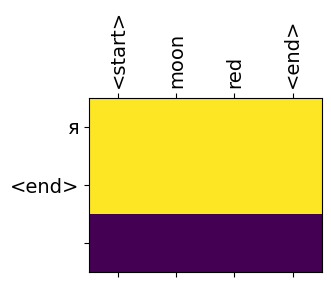

In [29]:
translate('moon red')

Текст для перевода: dog
tf.Tensor([[  1 399   2   0   0   0   0]], shape=(1, 7), dtype=int32)
Ввод: <start> dog <end>
Перевод: я <end> 


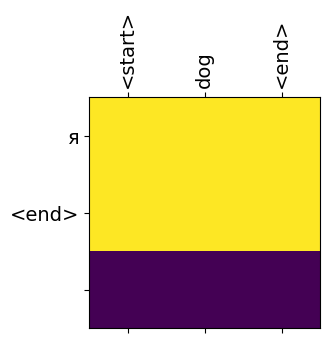

Перевод: None
Текст для перевода: moon
tf.Tensor([[1 2 0 0 0 0 0]], shape=(1, 7), dtype=int32)
Ввод: <start> moon <end>
Перевод: я <end> 


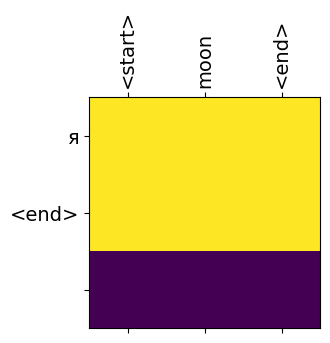

Перевод: None
Текст для перевода: q


In [33]:
# ЧАТ - БОТ

text = input("Текст для перевода: ")
while text != "q":
    print(f"Перевод: {translate(text)}")
    text = input("Текст для перевода: ")